# Hypersolvers for Optimal Control - Pre-training

### Basic usage of the `Hypersolver` API

We showcase the `torchdyn` API for [hypersolvers](https://arxiv.org/pdf/2007.09601.pdf). Hypersolvers, or hybrid ODE solvers equipped with a neural network to approximate residuals, are seamlessly integrated into the `odeint` API. A major design of the API is exactly preserving a persistent state for the solver, which in the case of standard ODE solvers contains the Tableau. For hypersolvers, the state also contains their hypernetwork parameters.

In [1]:
import sys; sys.path.append(2*'../') # go n dirs back
from src import *

In [2]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler

## Optimal Control

We want to control an inverted pendulum and stabilize it in the upright position. The equations in Hamiltonian form describing an inverted pendulum with a torsional spring are as following:

\begin{equation}
    \begin{bmatrix} \dot{q}\\ \dot{p}\\ \end{bmatrix} = 
    \begin{bmatrix}
    0& 1/m \\
    -k& -\beta/m\\
    \end{bmatrix}
    \begin{bmatrix} q\\ p\\ \end{bmatrix} -
    \begin{bmatrix}
    0\\
    mgl \sin{q}\\
    \end{bmatrix}+
    \begin{bmatrix}
    0\\
    1\\
    \end{bmatrix} u
\end{equation}

In [3]:
class ControlledPendulum(nn.Module):
    """
    Inverted pendulum with torsional spring
    """
    def __init__(self, u, m=1., k=.5, l=1., qr=0., β=.01, g=9.81):
        super().__init__()
        self.u = u # controller (nn.Module)
        self.nfe = 0 # number of function evaluations
        self.cur_f = None # current function evaluation
        self.cur_u = None # current controller evaluation 
        self.m, self.k, self.l, self.qr, self.β, self.g = m, k, l, qr, β, g # physics
        
    def forward(self, t, x):
        self.nfe += 1
        q, p = x[..., :1], x[..., 1:]
        self.cur_u = self.u(t, x)
        dq = p/self.m
        dp = -self.k*(q - self.qr) - self.m*self.g*self.l*torch.sin(q) \
            -self.β*p/self.m + self.cur_u
        self.cur_f = torch.cat([dq, dp], -1)
        return self.cur_f

In order to control the pendulum, we have to define a proper _integral cost function_ which will be our loss to be minimized during training. In a general form, it can be defined as:

\begin{equation}
        J = x^\top(t_f)\mathbf{P} x(t_f) + \int_{t_0}^{t_f} \left[ x^\top(t) \mathbf{Q} x(t) + u^\top(t) \mathbf{R} u(t) \right] dt
\end{equation}

where $ x = \begin{bmatrix} q\\ p\\ \end{bmatrix}$ is the state and $\mathbf{u}$ is the controller and matrices $\mathbf{P},~\mathbf{Q}, ~ \mathbf{R}$ are weights for controlling the performance.

In [4]:
class IntegralCost(nn.Module):
    '''Integral cost function
    Args:
        x_star: torch.tensor, target position
        P: float, terminal cost weights
        Q: float, state weights
        R: float, controller regulator weights
    '''
    def __init__(self, x_star, P=0, Q=1, R=0):
        super().__init__()
        self.x_star = x_star
        self.P, self.Q, self.R, = P, Q, R
        
    def forward(self, x, u=torch.Tensor([0.])):
        """
        x: trajectory
        u: control input
        """
        cost = self.P*torch.norm(x[-1] - self.x_star, p=2, dim=-1).mean()
        cost += self.Q*torch.norm(x - self.x_star, p=2, dim=-1).mean()
        cost += self.R*torch.norm(u - 0, p=2).mean()
        return cost

In [5]:
# Change device according to your configuration
# device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

In [6]:
# The controller is a simple MLP with one hidden layer with bounded output
class NeuralController(nn.Module):
    def __init__(self, model, u_min=-20, u_max=20):
        super().__init__()
        self.model = model
        self.u_min, self.u_max = u_min, u_max
        
    def forward(self, t, x):
        x = self.model(x)
        return torch.clamp(x, self.u_min, self.u_max)

model = nn.Sequential(nn.Linear(2, 32), nn.Tanh(), nn.Linear(32, 1)).to(device)
u = NeuralController(model) 
for p in u.model[-1].parameters(): torch.nn.init.zeros_(p)

# Controlled system
sys = ControlledPendulum(u).to(device)

In [7]:
from math import pi as π

# Loss function declaration
x_star = torch.Tensor([0., 0.]).to(device)
cost_func = IntegralCost(x_star)

# Time span
dt = 0.2
t0, tf = 0, 3 # initial and final time for controlling the system
steps = int((tf - t0)/dt) + 1 # so we have a time step of 0.2s
t_span = torch.linspace(t0, tf, steps).to(device)

# Initial distribution
x0 = π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0]), torch.Tensor([x0, x0]))

Now we have to address one question: can we speed up the simulation?

## Hypersolvers for Controlled Systems

By training the hypersolver on residuals between the ground-truth solution and the base solver (we will use Euler in this case) we can render the training more efficient while retaining solution accuracy.

The residuals can be defined by:
$$\begin{equation}
\begin{aligned}
    R \left(t_k,  x(t_k), x(t_{k+1}) \right) = \Phi(x(t_k), t_k, t_{k+1}) - x(t_k) - \epsilon f(x_k, u_k)
\end{aligned}
\end{equation}$$

where $\Phi$ is an accurate solver and $\epsilon$ is the time stepping.

The hypernet $g_w$ should have as input data important features for predicting future trajectories: we can use the current state $x$, its derivative $f$ and the control input $u$. The training will be carried out by minimizing a loss function like:

$$\begin{equation}
    \ell = \frac{1}{K} \sum_{k=0}^{K-1} \left|\left|{ R \left( t_k,  x(t_k), x(t_{k+1}) \right) - g_\omega\left(x(t_k), f(t_k), u(t_{k}) \right) }\right|\right|_2
\end{equation}$$

In [8]:
# We consider the controller fixed during each solver step
class RandConstController(nn.Module):
    def __init__(self):
        super().__init__()
        self.u0 = torch.Tensor(1024, 1).uniform_(-10,10).to(device)
        
    def forward(self, t, x):
        return self.u0
    
# Save previously learned controller
u_no_hypersolver = sys.u
sys.u = RandConstController() # modify controller for training

In [9]:
class VanillaHyperNet(nn.Module):
    """Simple hypernetwork for controlled systems
    Input: current x, f and u from the controlled system
    Output: p-th order residuals"""
    def __init__(self, net):
        super().__init__()
        self.net = net
        
    def forward(self, t, x):
        xfu = torch.cat([x, sys.cur_f, sys.cur_u], -1)
        return self.net(xfu)
    
net = nn.Sequential(nn.Linear(5, 32), nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 2))
hypersolver = HyperEuler(VanillaHyperNet(net))
# model = nn.DataParallel(hypersolver, device_ids=[1]) # feel free to change here according to your setup and GPU available.
# model = model.to(device)

## Training the Hypernetwork

Training the hypernetwork $g_w$ requires us to know which set its input values are contained in.
If we want the pendulum with initial states in $\pm \pi$, we can sample the input states for the hypernetwork from a distribution which includes possible states which the system can visit (i.e., the hypernetwork should be able to predict outside of the initial boundaries in a certain range). For example, we can draw the states $x$ from a Uniform distribution:
$$x = \begin{bmatrix} q\\ p\\ \end{bmatrix} \sim Uniform(-2\pi, 2\pi) \times Uniform(-2\pi, 2\pi)$$
Similarly, the controller values can be sampled from a distribution including all the possible controller values, such as
$$u \sim Uniform(-20, 20)$$

In [10]:
# Initial distribution
x0 = 2*π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0]), torch.Tensor([x0, x0]))

base_solver = Euler()
# Time span
t0, tf = 0, 3 # initial and final time for controlling the system
steps = int((tf - t0)/dt) + 1 # so we have a time step of 0.2s
t_span = torch.linspace(t0, tf, steps).to(device)
dt = (t_span[1] - t_span[0]).detach().cpu().item()

In [11]:
opt = torch.optim.Adam(hypersolver.parameters(), lr=3e-4)
loss_func = nn.MSELoss()
epochs = 300000
bs = 2048
# hypernet = model.module.hyperne
hypernet = hypersolver.hypernet
span = torch.linspace(0, dt, 2)
losses = []

for i in range(epochs):
    # Sample random intial states and controllers
    x0 = init_dist.sample((bs,)).to(device)
    sys.u.u0 = torch.Tensor(bs, 1).uniform_(-5, 5).to(device)
    
     # Compute residuals
    _, sol_gt = odeint(sys, x0, span, solver='tsit5', atol=1e-5, rtol=1e-5)[-1]
    sol = x0 + sys(0., x0)*dt
    residuals = (sol_gt - sol) / dt**2
    residuals_hypersolver = hypernet(0., x0)
    loss = loss_func(residuals, residuals_hypersolver)

    # Optimization step
    loss.backward(); opt.step(); opt.zero_grad()
    print(f'Step: {i}, Residual loss: {loss:.3f}', end='\r')
    losses.append(loss.detach().cpu().item())

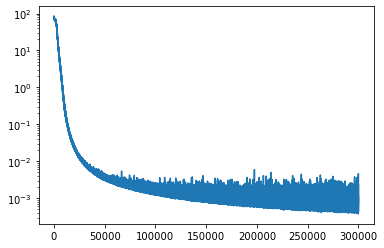

In [12]:
plt.plot(losses)
plt.yscale('log')

In [13]:
torch.save(model, 'saved_models/hs_torchdyn.pt')

Text(0.5, 0.98, 'Uncontrolled Trajectories')

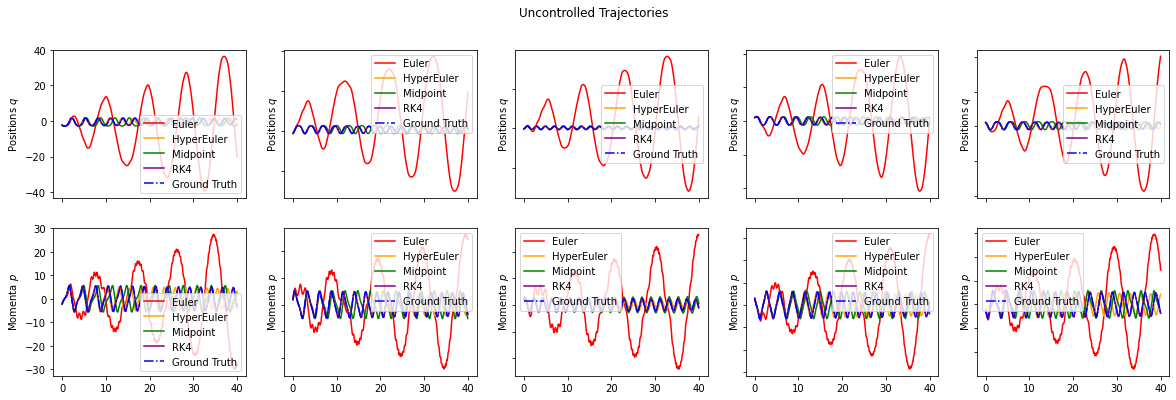

In [16]:
# Sample and plot some trajectories
x0 = π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0]), torch.Tensor([x0, x0]))
x0 = init_dist.sample((10000,)).to(device)
sys = ControlledPendulum(RandConstController()).to(device)
sys.u.u0 = torch.Tensor(10000, 1).uniform_(-3,3).to(device)
t_span = torch.linspace(0, 40, 401).to(device)

_, traj_euler = odeint(sys, x0, t_span, solver='euler')
_, traj_hyper = odeint(sys, x0, t_span, solver=hypersolver)
_, traj_mp = odeint(sys, x0, t_span, solver='midpoint')
_, traj_rk4 = odeint(sys, x0, t_span, solver='rk4')
_, traj_gt = odeint(sys, x0, t_span, solver='tsit5', atol=1e-5, rtol=1e-5)
traj_euler = traj_euler.detach().cpu(); traj_hyper = traj_hyper.detach().cpu(); traj_gt = traj_gt.detach().cpu()
traj_mp = traj_mp.detach().cpu(); traj_rk4 = traj_rk4.detach().cpu()
t_span = t_span.cpu()

fig, axs = plt.subplots(2, 5, figsize=(20,6))

for i in range(5):
    for j in range(2):
        axs[j, i].plot(t_span, traj_euler[:,i,j], 'r')
        axs[j, i].plot(t_span, traj_hyper[:,i,j], 'orange')
        axs[j, i].plot(t_span, traj_mp[:,i,j], 'green')
        axs[j, i].plot(t_span, traj_rk4[:,i,j], 'purple')
        axs[j, i].plot(t_span, traj_gt[:,i,j], 'b-.')
        axs[j, i].legend(['Euler', 'HyperEuler', 'Midpoint', 'RK4', 'Ground Truth'])
        axs[j, i].label_outer()
    axs[0, i].set_ylabel(r'Positions $q$'); axs[1, i].set_ylabel(r'Momenta $p$')

fig.suptitle('Uncontrolled Trajectories')

Text(0.5, 0.98, 'SMAPE Propagation')

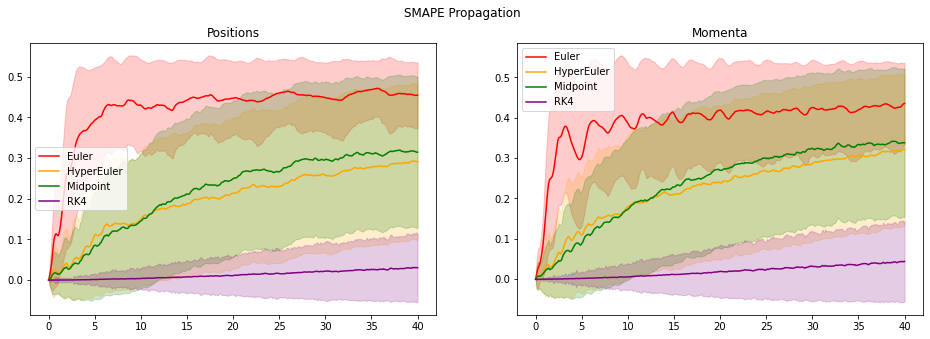

In [17]:
# Error analysis
def smape(yhat, y):
    return torch.abs(yhat - y) / (torch.abs(yhat) + torch.abs(y)) / 2

err_euler = smape(traj_gt, traj_euler).detach().cpu();  err_hyper = smape(traj_gt, traj_hyper).detach().cpu()
err_mp, err_rk4 = smape(traj_gt, traj_mp).detach().cpu(), smape(traj_gt, traj_rk4).detach().cpu()
mean_euler, std_euler = err_euler.mean(1), err_euler.std(1)
mean_hyper, std_hyper = err_hyper.mean(1), err_hyper.std(1)
mean_mp, std_mp = err_mp.mean(1), err_mp.std(1)
mean_rk4, std_rk4 = err_rk4.mean(1), err_rk4.std(1)

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,2,1)
ax.plot(t_span, mean_euler[:,0], 'r', label='Euler')
ax.plot(t_span, mean_hyper[:,0], 'orange', label='HyperEuler')
ax.plot(t_span, mean_mp[:,0], 'green', label='Midpoint')
ax.plot(t_span, mean_rk4[:,0], 'purple', label='RK4')

ax.fill_between(t_span, mean_euler[:,0]-std_euler[:,0], mean_euler[:,0]+std_euler[:,0], alpha=.2, color='r')
ax.fill_between(t_span, mean_hyper[:,0]-std_hyper[:,0], mean_hyper[:,0]+std_hyper[:,0], alpha=.2, color='orange')
ax.fill_between(t_span, mean_mp[:,0]-std_mp[:,0], mean_mp[:,0]+std_mp[:,0], alpha=.2, color='green')
ax.fill_between(t_span, mean_rk4[:,0]-std_rk4[:,0], mean_rk4[:,0]+std_rk4[:,0], alpha=.2, color='purple')

ax.legend()
ax.set_title('Positions')

ax = fig.add_subplot(1,2,2)
ax.plot(t_span, mean_euler[:,1], 'r', label='Euler')
ax.plot(t_span, mean_hyper[:,1], 'orange', label='HyperEuler')
ax.plot(t_span, mean_mp[:,1], 'green', label='Midpoint')
ax.plot(t_span, mean_rk4[:,1], 'purple', label='RK4')

ax.fill_between(t_span, mean_euler[:,1]-std_euler[:,1], mean_euler[:,1]+std_euler[:,1], alpha=.2, color='r')
ax.fill_between(t_span, mean_hyper[:,1]-std_hyper[:,1], mean_hyper[:,1]+std_hyper[:,1], alpha=.2, color='orange')
ax.fill_between(t_span, mean_mp[:,1]-std_mp[:,1], mean_mp[:,1]+std_mp[:,1], alpha=.2, color='green')
ax.fill_between(t_span, mean_rk4[:,1]-std_rk4[:,1], mean_rk4[:,1]+std_rk4[:,1], alpha=.2, color='purple')
ax.legend()
ax.set_title('Momenta')
fig.suptitle('SMAPE Propagation')

Nice! We managed obtain a more accurate solver with respect to the Euler baseline. Now, let's see how this performs with optimal control.